# 03/20/24 - This notebook demonstrates the process of using slacs_kcwi_kinematics.py

In [3]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pathlib # to create directory
import dill as pickle
from datetime import datetime
import os

from ppxf.ppxf import ppxf
from pathlib import Path
from scipy import ndimage
from urllib import request
from scipy import ndimage
from time import perf_counter as clock
from scipy import interpolate
from astropy.visualization import simple_norm
from astropy.modeling.models import Sersic2D
import astropy.units as u
from vorbin.voronoi_2d_binning import voronoi_2d_binning


# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages/ppxf_kcwi_util_022423")
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages/")

from slacs_kcwi_kinematics import slacs_kcwi_kinematics

c = 299792.458 # km/s

In [4]:
#################################################
# objects
obj_names = ['SDSSJ0029-0055', 
             'SDSSJ0037-0942',
             'SDSSJ0330-0020',
             'SDSSJ1112+0826',
             'SDSSJ1204+0358',
             'SDSSJ1250+0523',
             'SDSSJ1306+0600',
             'SDSSJ1402+6321',
             'SDSSJ1531-0105',
             'SDSSJ1538+5817',
             'SDSSJ1621+3931',
             'SDSSJ1627-0053',
             'SDSSJ1630+4520',
             'SDSSJ2303+1422'
            ]

In [5]:
# Universal parameters
# todays date
date = datetime.now().strftime("%Y_%m_%d")
# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
kinematics_dir = f'{data_dir}kinematics/{date}/'
if not os.path.exists(kinematics_dir):
    os.mkdir(kinematics_dir)
    
#------------------------------------------------------------------------------
# Kinematics systematics initial choices
# aperture
aperture = 'R2'
# wavelength range
wave_min = 3400
wave_max = 4300 ########### NOTE J0330 will be different
# degree of the additive Legendre polynomial in ppxf
degree = 4 # 900/250 = 3.6 round up

#------------------------------------------------------------------------------
# Information specific to KCWI and templates
kcwi_scale = 0.1457
## R=3600. spectral resolution is ~ 1.42A
FWHM_data = 1.42 #1.42
## initial estimate of the noise
noise = 0.014
# velocity scale ratio
velscale_ratio = 2
# FWHM of templates
FWHM_xshooter = 0.403 # Angstroms
FWHM_emiles = 2.51 # Angstroms
# central wavelength is where we measure FWHM
central_wavelength = 3950

#------------------------------------------------------------------------------
# variable settings in ppxf and utility functions
# cut the datacube at lens center, radius given here
radius_in_pixels = 21
# target SN for voronoi binning
#vorbin_SN_targets = np.array([10, 15, 20])
bin_target_SN = 15.
# minimum SN of pixels to be included in voronoi bining
pixel_min_SN = 1.
# stellar population
sps_names = ['xshooter','emiles']


library_vds = np.zeros((len(obj_names), len(sps_names)))


__________
# J0029

In [6]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ0029-0055'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.227 # lens redshift
T_exp = 1800*5 # exposure time in seconds... this is where I made the disastrous mistake
lens_center_x,lens_center_y = 61, 129

# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'

mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'
plot_bin_fits=False

In [24]:
# xshooter

sps_name = 'xshooter'

print('#######################################################################')

if sps_name == 'xshooter':
    FWHM_templates = FWHM_xshooter
elif sps_name == 'emiles':
    FWHM_templates = FWHM_emiles

j0029_kinematics = slacs_kcwi_kinematics(
                                         mos_dir=mos_dir,
                                         kin_dir=kin_dir,
                                         obj_name=obj_name,
                                         kcwi_datacube_file=kcwi_datacube,
                                         central_spectrum_file=central_spectrum_file,
                                         background_spectrum_file=None,
                                         background_source_mask_file=background_source_mask_file,
                                         zlens=zlens,
                                         exp_time=T_exp,
                                         lens_center_x=lens_center_x,
                                         lens_center_y=lens_center_y,
                                         aperture=aperture,
                                         wave_min=wave_min,
                                         wave_max=wave_max,
                                         degree=degree,
                                         sps_name=sps_name,
                                         FWHM_templates=FWHM_templates,
                                         FWHM_data=FWHM_data,
                                         pixel_scale=kcwi_scale,
                                         noise=noise,
                                         central_wavelength=central_wavelength,
                                         velscale_ratio=velscale_ratio,
                                         radius_in_pixels=radius_in_pixels,
                                         bin_target_SN=bin_target_SN,
                                         pixel_min_SN=pixel_min_SN,
                                         plot=True,
                                         quiet=False
)



#######################################################################


# Visualize the summed datacube


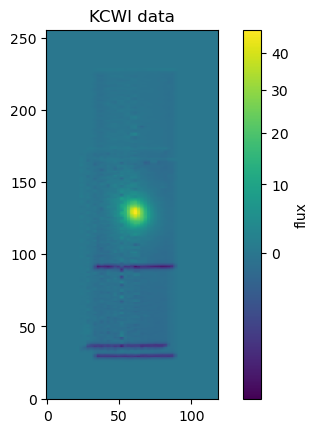

In [25]:
print('# Visualize the summed datacube')
j0029_kinematics.datacube_visualization()



In [26]:
print('# rebin the central spectrum in log wavelengths and prepare for fitting')
j0029_kinematics.log_rebin_central_spectrum()
print()

print('# same with background spectrum')
j0029_kinematics.log_rebin_background_spectrum()
print()

print('# prepare the templates from the sps model')
j0029_kinematics.get_templates()



# rebin the central spectrum in log wavelengths and prepare for fitting

# same with background spectrum

# prepare the templates from the sps model
Templates do not cover galaxy lower wavelength range. Adding zeros.
Check this fit to be sure the 0s are not in the fit range.


# set up the wavelengths that will be fit, masks a couple gas lines

# fit the central spectrum to create the global_template
 Best Fit:       Vel     sigma
 comp.  0:       291       231
chi2/DOF: 0.1684; DOF: 1969; degree = 4; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 18/629


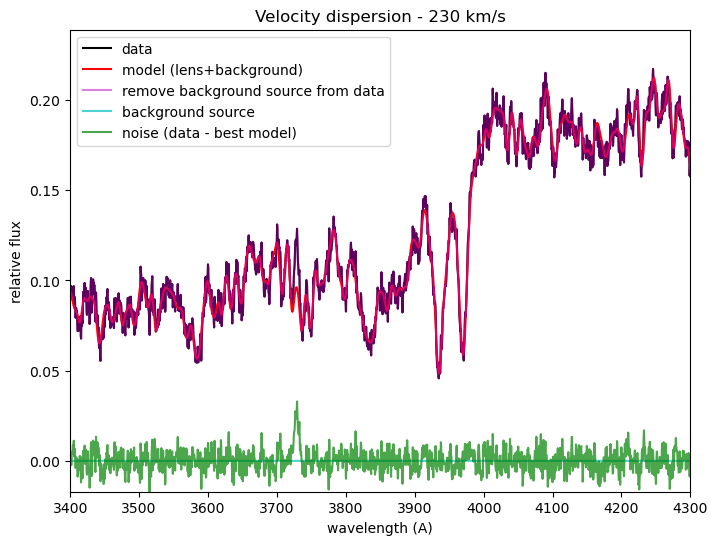

Formal errors:
     dV    dsigma   dh3      dh4
       4     4.1
Elapsed time in pPXF: 4.01 s


In [27]:
print('# set up the wavelengths that will be fit, masks a couple gas lines')
j0029_kinematics.set_up_mask()
print()

print('# fit the central spectrum to create the global_template')
j0029_kinematics.ppxf_central_spectrum()



# crop the datacube to a smaller size


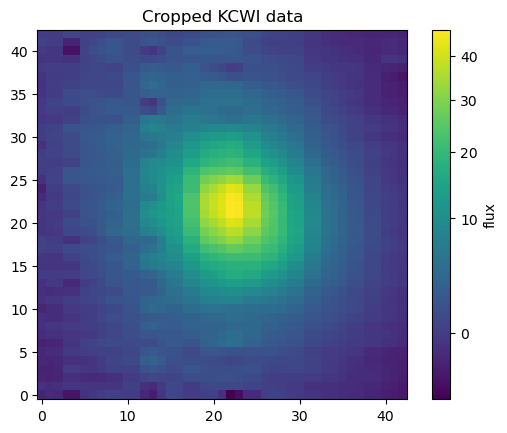

In [28]:
print('# crop the datacube to a smaller size')
j0029_kinematics.crop_datacube()



# create a S/N map to get the Voronoi binning going


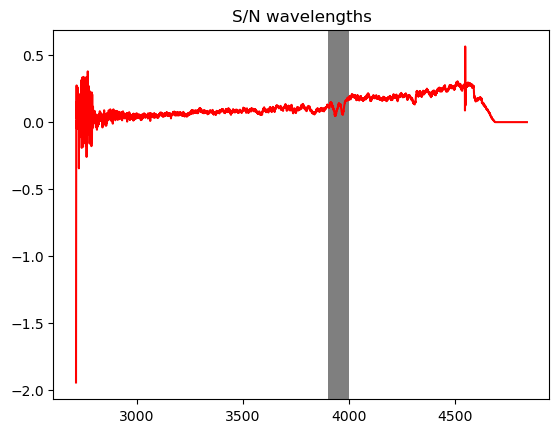

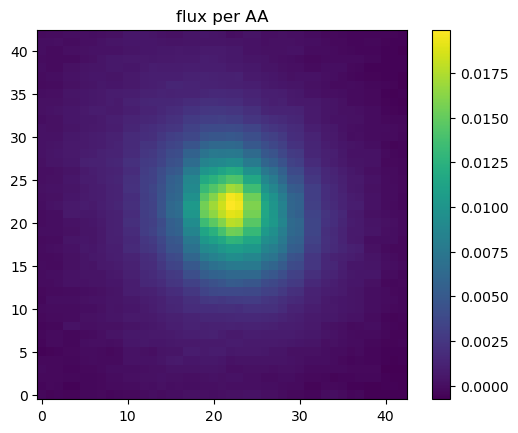

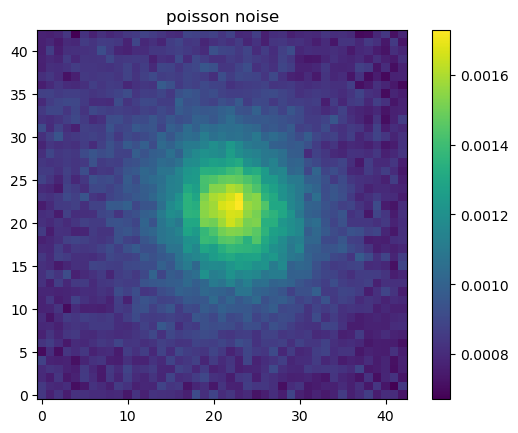

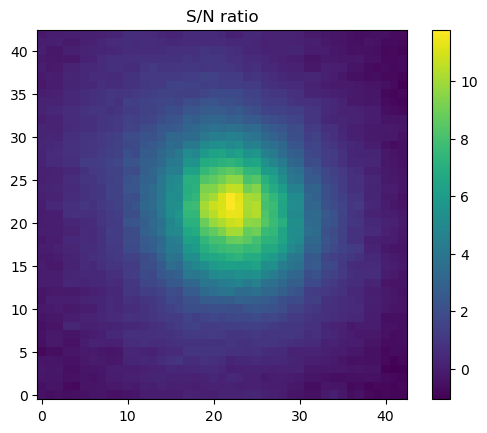

In [29]:
print('# create a S/N map to get the Voronoi binning going')
j0029_kinematics.create_SN_map()



# select the spaxels S/N > 1 that will be binned


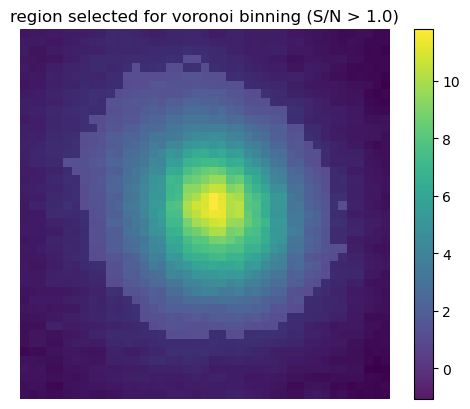


# bin the selected spaxels to the target S/N


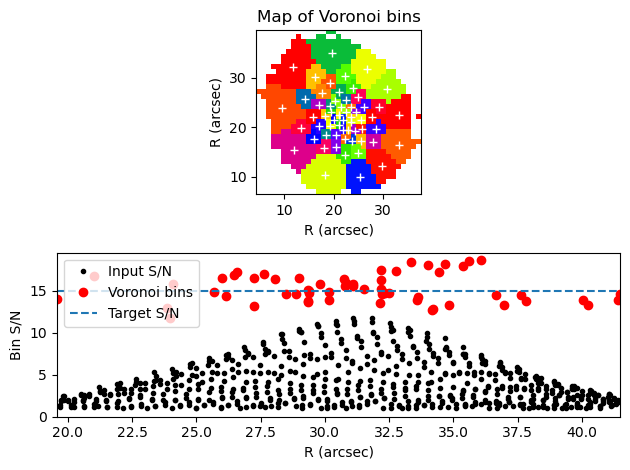

Number of bins = 59


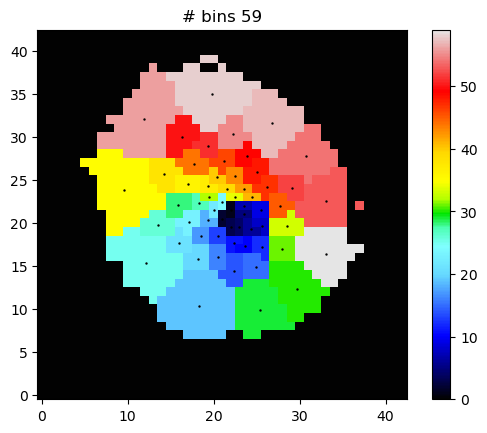

In [30]:
print('# select the spaxels S/N > 1 that will be binned')
j0029_kinematics.select_region() 
print()

print('# bin the selected spaxels to the target S/N')
j0029_kinematics.voronoi_binning()



In [31]:
print('# fit each bin spectrum with global_template')
j0029_kinematics.ppxf_bin_spectra(plot_bin_fits=plot_bin_fits)



# fit each bin spectrum with global_template


# create the 2d kinematic maps from ppxf fits

# plot those maps


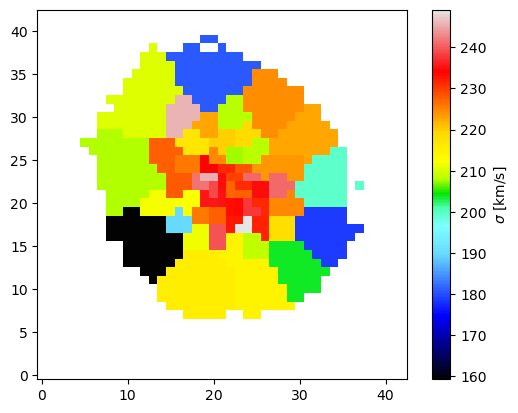

<Figure size 640x480 with 0 Axes>

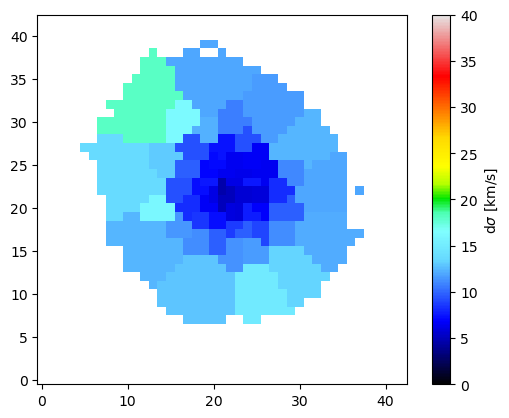

<Figure size 640x480 with 0 Axes>

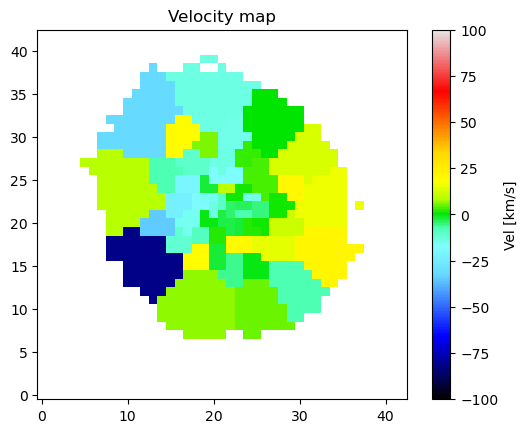

<Figure size 640x480 with 0 Axes>

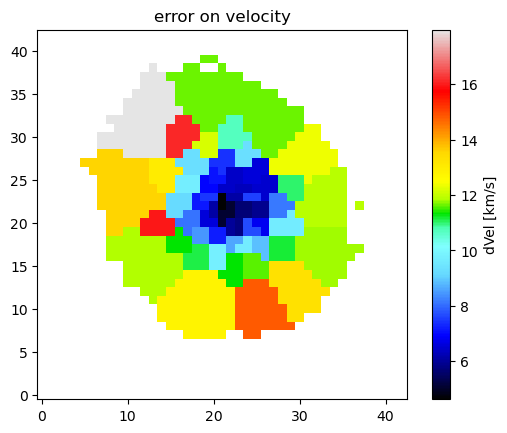

<Figure size 640x480 with 0 Axes>

In [32]:
print('# create the 2d kinematic maps from ppxf fits')
j0029_kinematics.make_kinematic_maps()
print()

print('# plot those maps')
j0029_kinematics.plot_kinematic_maps()